# MERRA-2 Data Download

This notebook includes python code used to download MERRA-2 data via OPeNDAP. Before data download, follow these [**instructions**](https://disc.gsfc.nasa.gov/data-access#opendap) provded by Earthdata:
1. **Create an Earthdata account**
2. **Link GES DISC with your account**
3. **Create .netrc and .urs_cookies files** (see wget section at https://disc.gsfc.nasa.gov/data-access#opendap)
4. **Create a .dodsrc file in your home directory** (see ncdump section at https://disc.gsfc.nasa.gov/data-access#opendap; points to .netrc file for password information)

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate as integ
import pandas as pd
import calendar
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, wait
import scipy.stats as sp
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Note that this example notebook launches Dask on a SLURM cluster. The details of the cluster will likely need to be changed; alternatively, with some minor changes, this code can be run without dask (e.g., change ``client.persist`` and ``client.gather``).

Also note that some dataset and array names do not exactly match the results notebook, efficiency_results.ipynb.

In [2]:
cluster = SLURMCluster(processes=1,
            #threads=1,
            memory="16GB",
            cores=8,
            #project='',
            #walltime='',
            #interface='',
            #ip='',
            scheduler_options={"dashboard_address": ":8787"},
            queue="snow")

In [3]:
cluster.adapt(minimum=1,maximum=1)

In [4]:
client = Client(cluster)

In [5]:
#link to the dashboard 
client

Client Scheduler: tcp://169.226.65.22:43319 Dashboard: http://169.226.65.22:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## 1 Poleward Atmospheric Energy Fluxes

### 1.a) Energy Flux with xarray

Since ``xr.open_mfdataset()`` does not work in this case, the following code opens each url individually (``xr.open_dataset``), combines them, and calculates the daily mean moist static energy (MSE) flux. This code computes the MSE flux in monthly increments with the client restarting between months, keeping the data storage relatively small, and follows Eqs. 2 and A1 in Cardinale et al. (2021), https://doi.org/10.1175/jcli-d-20-0722.1. As specified in Cardinale et al. (2021), contributions from the net mass flux (NMF) are neglected. 

All urls can be updated with other MERRA-2 [**data collections**](https://gmao.gsfc.nasa.gov/pubs/docs/Bosilovich785.pdf) (full urls can be found at https://goldsmr5.gesdisc.eosdis.nasa.gov/opendap/MERRA2/).

In [6]:
def read_netcdfs(files, dim):
    def process_one_path(path):
        with xr.open_dataset(path,chunks={'time': 8}) as ds:
            return client.persist(ds,retries=200)
    paths = files
    datasets = [process_one_path(p) for p in paths]
    datasets = client.gather(datasets)
    combined = (xr.concat(datasets, dim))
    return combined
#this example code only computes the energy flux for January 1980
#use the following lines instead to calculate the flux for all months from 1980-2020
#for y in range(1980,2021):
    #for m in range(1,13):
for y in 1980,:
    for m in 1,:
        #constants
        g = 9.81
        Lv = 2.5e6
        Cp = 1004.
        
        #circumference at 70N and area poleward of 70N
        c = 40075000. * np.cos(np.deg2rad(70.))
        a = (2.*6371000.**2*np.pi)*(np.sin(np.deg2rad(90.))-np.sin(np.deg2rad(70.))) 
        def h(circ=c,area=a):
            """conversion factor:
            energy flux to local MSE flux convergence (W/m2/100 hPa)"""
            return (circ/(area*g))*10**4

        start_year = y
        end_year = y
        start_month = m
        end_month = m
        start_day = 1
        end_day = calendar.monthrange(end_year,end_month)[1]

        dataset_name = 'merra2_ET_{}_{}'.format(end_year
                                                  ,calendar.month_abbr[end_month])
        dataset_name2 = 'MERRA2_EDDY_{}_{}'.format(end_year
                                                  ,calendar.month_abbr[end_month])
        time = pd.date_range('{}-{}-{}'.format(start_year,start_month,start_day)
                             ,'{}-{}-{}'.format(end_year,end_month,end_day))
        year = (time.strftime('%Y'))
        month = (time.strftime('%m'))
        date = (time.strftime('%Y%m%d'))
        decade = []
        for x in range(len(time)):
            if 1979 < int(year[x]) < 1992:
                decade.append('1')
            if 1991 < int(year[x]) < 2001:
                decade.append('2')
            if 2000 < int(year[x]) < 2011:
                decade.append('3')
            if 2010 < int(year[x]) < 2021:
                decade.append('4')    

        url = []
        for x in range(len(time)):

            url.append('https://goldsmr5.gesdisc.eosdis.nasa.gov:443/opendap/MERRA2/M2I3NPASM.5.12.4/{}/{}/MERRA2_{}00.inst3_3d_asm_Np.{}.nc4?V[0:1:7][0:1:41][320][0:1:575],T[0:1:7][0:1:41][320][0:1:575],QV[0:1:7][0:1:41][320][0:1:575],H[0:1:7][0:1:41][320][0:1:575],lat[320],lev[0:1:41],lon[0:1:575],time[0:1:7]'
                           .format(year[x],month[x],decade[x],date[x]))

        merra=read_netcdfs(files= url,dim='time')
        #waits until data is downloaded to start the flux calculations
        wait(merra)
        merra=merra.rename({'T': 'TEMP'}).sel(lat=70)
        
        #To account for topography in the pressure level dataset,
        #the following method replaces nan values with 0 in areas of topography.
        
        def bracket(array):
            """zonal mean"""
            return array.mean(dim='lon')
        
        def bracket2(array):
            """Alternate zonal mean function, which accounts for topography without replacing nans."""
            return xr.DataArray(np.squeeze(integ.trapz(array.to_masked_array(),x=array.lon,axis=-1)) / 359.375
                        ,coords=[array.time,array.lev],dims=['time','lev'])

        def bar(array):
            """time mean"""
            return array.mean(dim='time')

        def star(array):
            """departure fomr the zonal mean"""
            return array - bracket(array)
        
        def ufunc(array,function):
            """Use with integrate and curly_bracket functions
            to preserve the labeled coordinates and dimensions of the DataArray."""
            return xr.apply_ufunc(
                function, array,
                input_core_dims=[['lev']],
                exclude_dims={'lev'},
                dask='allowed',
                output_dtypes=[float])

        def curly_bracket(array):
            """Computes the mass weighted vertical average.
            Note that the integrate function has changed in the latest SciPy release."""
            return (((np.squeeze(integ.trapz(array,x=-(merra.lev*10**2)/g,axis=-1)))) 
                    / ((100000. / g))) 
        
        def double_prime(array):
            """departure from the mass weighted vertical average"""
            return array - (ufunc(array,curly_bracket))
        
        def integrate(array):
            """Computes the vertical integral (trapezoidal Rule)."""
            return (np.squeeze(integ.trapz(array,x=-(merra.lev*10**2)/g,axis=-1)))
        
        
        def tile_lev_gufunc(ds):
            return np.transpose((np.tile(merra.lev,(len(ds[:,0,0]),576,1))),(0,2,1))

        def tile_lev(ds):
            return xr.apply_ufunc(
            tile_lev_gufunc, ds,
            dask='allowed',
            output_dtypes=[float]) 

        def lev_field(ds):
            """Used to find the highest pressure level at every time and longitude"""
            lev_field = tile_lev(ds.V)
            lev_field = ((lev_field*(ds.V.isnull()==False)).where((lev_field*(ds.V.isnull()==False))>0))
            return lev_field

        lev_mesh=lev_field(merra)

        def tilde(array):
            """Alternate method for calculating the zonal mean of the mass weighted vertical average."""
            return xr.DataArray(((np.squeeze(integ.trapz(array.to_masked_array(),x=-(merra.lev*10**2)/g,axis=1))).mean(-1)
                    / bracket(lev_mesh.max('lev').sel(time=array.time)*10**2 / g)).data,coords=[merra.time],dims=['time'])


        def eddy(wind,energy):
            return bracket(((star(wind.fillna(0))) * (star(energy.fillna(0)))))
        
        def eddy_zonal(wind,energy):
            """Use this function for the zonal struction of the eddy flux and the contribution of 
            the eddy flux to the MSE flux."""
            return (star(wind) * star(energy)).fillna(0)

        def mmc(wind,energy):
            return (double_prime(bracket(wind.fillna(0))) 
                    * double_prime(bracket(energy.fillna(0))))
        
        def mse(wind,energy):
            """Method used for MSE calculation in the paper"""
            eddy_flux = eddy(wind,energy)
            mmc_flux = mmc(wind,energy)
            return eddy_flux + mmc_flux
        
        def mse_liang(wind,energy,pc_avg_energy):
            """Method from Liang et al. 2018 (https://doi.org/10.1007/s00382-017-3722-x.) 
            You can assume the winter and polar cap-averaged MSE to be about 300000 J/m2, but for
            for increased accuracy, download the polar cap data poleward of 70N and apply the following 
            area (average function) and vertical (curly_bracket function) averaging:
            
            def average(ds):
                lon=ds.lon
                lat=ds.lat
                lat_field = xr.broadcast(lat,lon)[0]
                lat_field = (lat_field*(ds.isnull()==False)).where((lat_field*(ds.isnull()==False))>0)
                weights=np.cos(np.deg2rad(lat_field))/np.cos(np.deg2rad(lat_field)).mean('lat')
                avg = (ds*weights).mean(['lon','lat'])
                return avg
            
            pc_avg_energy=curly_bracket(average(merra.TEMP*Cp+merra.H*g+merra.QV*Lv))
            """
            return (bracket((wind * (energy-pc_avg_energy)).fillna(0)))
        
        def f_wall(wind,energy):
            """vertically integrated MSE flux at 70N in W/m2 
            (i.e., the polar cap-averaged MSE flux convergence)"""
            return ufunc(bracket((wind * energy).fillna(0)),integrate)*c/a
        
        #meanV is the mass weighted vertical average meridional wind 
        #subtracting meanV from V removes contributions from the net mass flux
        meanV = ufunc(bracket(merra.V.fillna(0)),curly_bracket).persist()
        meanV2 = tilde(merra.V.fillna(0)).persist()
        merra = merra.assign(V_c = (merra.V - meanV))
        merra = merra.assign(V_c2 = (merra.V - meanV2))
        
        SH = (merra.TEMP * Cp)
        GP = (merra.H * g)
        LH = (merra.QV * Lv)

        SH_flux = mse(merra.V, SH).groupby('time.dayofyear').mean('time') 
        GP_flux = mse(merra.V, GP).groupby('time.dayofyear').mean('time') 
        LH_flux = mse(merra.V, LH).groupby('time.dayofyear').mean('time') 
        EDDY_flux = eddy_zonal(merra.V,SH+GP+LH).groupby('time.dayofyear').mean('time')
        F_WALL = f_wall(merra.V_c, SH+LH+GP).groupby('time.dayofyear').mean('time')
        F_WALL2 = f_wall(merra.V_c2, SH+LH+GP).groupby('time.dayofyear').mean('time')
        MSE_liang = mse_liang(merra.V,SH+GP+LH,300000).groupby('time.dayofyear').mean('time')

        combined_SH = xr.DataArray(SH_flux,coords=[time,merra.lev],dims=['time','lev']).compute()
        combined_GP = xr.DataArray(GP_flux,coords=[time,merra.lev],dims=['time','lev']).compute()
        combined_LH = xr.DataArray(LH_flux,coords=[time,merra.lev],dims=['time','lev']).compute()
        combined_EDDY = xr.DataArray(EDDY_flux,coords=[time,merra.lev,merra.lon],dims=['time','lev','lon']).compute()
        combined_F = xr.DataArray(F_WALL,coords=[time],dims=['time']).compute()
        combined_F2 = xr.DataArray(F_WALL2,coords=[time],dims=['time']).compute()
        combined_MSE_liang = xr.DataArray(MSE_liang,coords=[time,merra.lev],dims=['time','lev']).compute()
        
        EDDY_SH_flux = eddy_zonal(merra.V,SH).groupby('time.dayofyear').mean('time')
        EDDY_LH_flux = eddy_zonal(merra.V,LH).groupby('time.dayofyear').mean('time')
        EDDY_GP_flux = eddy_zonal(merra.V,GP).groupby('time.dayofyear').mean('time')
        combined_EDDY_SH = xr.DataArray(EDDY_SH_flux,coords=[time,merra.lev,merra.lon],dims=['time','lev','lon']).compute()
        combined_EDDY_LH = xr.DataArray(EDDY_LH_flux,coords=[time,merra.lev,merra.lon],dims=['time','lev','lon']).compute()
        combined_EDDY_GP = xr.DataArray(EDDY_GP_flux,coords=[time,merra.lev,merra.lon],dims=['time','lev','lon']).compute()

        merra_ET = xr.Dataset({'SH':combined_SH,'GP':combined_GP,'LH':combined_LH})
        merra_EDDY = xr.Dataset({'EDDY_SH':combined_EDDY_SH,'EDDY_GP':combined_EDDY_GP,'EDDY_LH':combined_EDDY_LH})
        #uncomment following lines to save the datasets
        #data_loc = 'condensed_data/'
        #merra_ET.to_netcdf(data_loc+dataset_name)
        #merra_EDDY.to_netcdf(data_loc+dataset_name2)
        client.restart()

### 1.b) Energy Flux Comparisons

All methods described in the above code for calculating the total polar cap&ndash;averaged MSE flux convergence poleward of 70N results in approximately the same flux convergence.

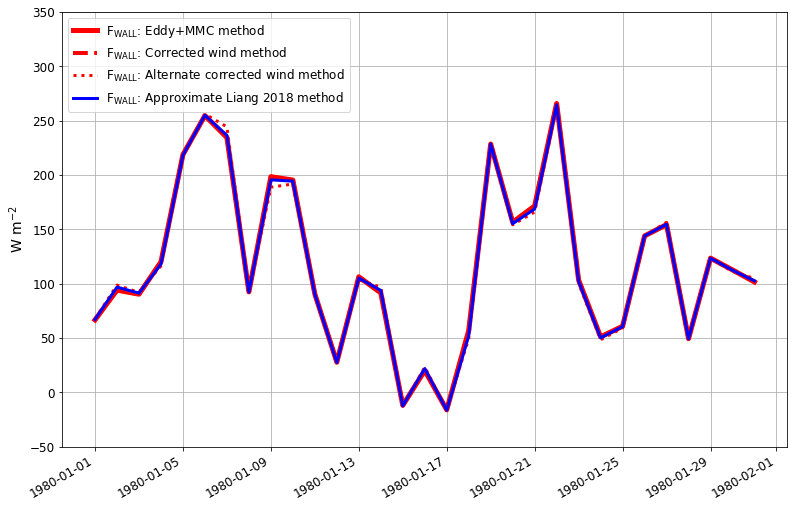

In [7]:
fig = plt.figure( figsize=(13,8) )
ax = fig.add_subplot(111)
ufunc((merra_ET.SH+merra_ET.LH+merra_ET.GP)*c/a,integrate).plot(ax=ax,color='r',ls='-',label='F$_{\mathrm{WALL}}$: Eddy+MMC method ',lw=5)
(combined_F).plot(ax=ax,color='r',ls='--',label='F$_{\mathrm{WALL}}$: Corrected wind method',lw=4)
(combined_F2).plot(ax=ax,color='r',ls=':',label='F$_{\mathrm{WALL}}$: Alternate corrected wind method',lw=3)
ufunc(combined_MSE_liang*c/a,integrate).plot(ax=ax,color='b',ls='-',label='F$_{\mathrm{WALL}}$: Approximate Liang 2018 method',lw=3)
ax.grid()
ax.legend(fontsize=12)
ax.set_ybound(-50,350)
#ax.set_yticklabels(np.arange(-50,400,50),fontsize=12)
ax.tick_params(labelsize=12)
ax.set_ylabel('W m$^{-2}$',fontsize=14)
ax.set_xlabel('',fontsize=14);

The following plot shows the mean January 1980 local MSE flux convergence with contributions from the SH, LH, GP, and EDDY contributions. The method used in this manuscript (solid black line) is in agreement with the approximate Liang method (dashed balck line). For the method detailed in Liang et al. 2018 (https://doi.org/10.1007/s00382-017-3722-x.), we assume the polar cap&ndash;averaged MSE is fixed at 300000 J m$^{-2}$ (or 300 KJ m$^{-2}$). For a more accurate flux, remove the polar cap&ndash;averaged MSE at every time-step (see above code for details).

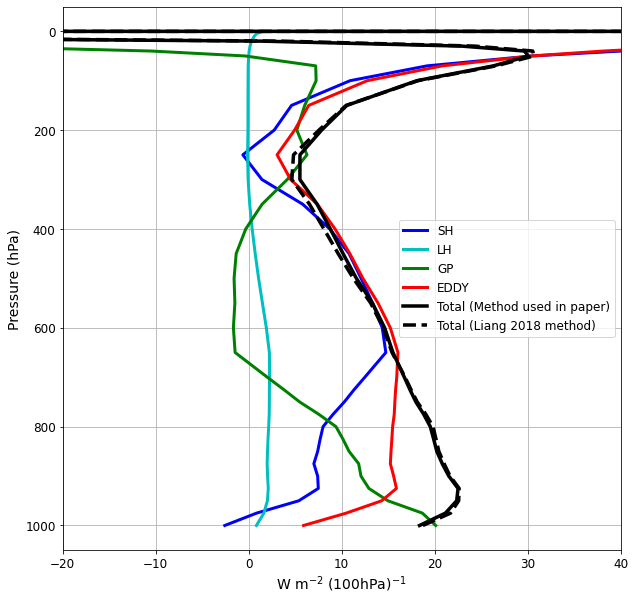

In [8]:
fig = plt.figure( figsize=(10,10) )
ax = fig.add_subplot(111)
(merra_ET.SH.mean('time')*h()).plot(y='lev', yincrease=False,ax=ax,color='b',lw=3,label='SH')
(merra_ET.LH.mean('time')*h()).plot(y='lev', yincrease=False,ax=ax,color='c',lw=3,label='LH')
(merra_ET.GP.mean('time')*h()).plot(y='lev', yincrease=False,ax=ax,color='g',lw=3,label='GP')
(combined_EDDY.mean(['time','lon'])*h()).plot(y='lev', yincrease=False,ax=ax,color='r',ls='-',lw=3,label='EDDY')
((merra_ET.SH+merra_ET.LH+merra_ET.GP).mean('time')*h()).plot(y='lev', yincrease=False,ax=ax,color='k',lw=3.5
                                                              ,label='Total (Method used in paper)')
((combined_MSE_liang).mean('time')*h()).plot(y='lev', yincrease=False,ax=ax,color='k',ls='--',lw=3.5
                                             ,label='Total (Liang 2018 method)')
ax.grid()
ax.legend(fontsize=12)
ax.set_xbound(-20,40)
ax.tick_params(labelsize=12)
ax.set_ylabel('Pressure (hPa)',fontsize=14)
ax.set_xlabel('W m$^{-2}$ (100hPa)$^{-1}$',fontsize=14);

## 2. Moist Enthalpy

The following code computes the polar cap&ndash;averaged (70&ndash;90N) moist enthalpy (combined sensible and latent heat).

In [9]:
def read_netcdfs(files, dim):
    def process_one_path(path):
        with xr.open_dataset(path,chunks={'time': 8}) as ds:
            return client.persist(ds,retries=200)
    paths = files
    datasets = [process_one_path(p) for p in paths]
    datasets = client.gather(datasets)
    combined = (xr.concat(datasets, dim))
    return combined
#this example code only computes the moist enthalpy for January 1980
#use the following lines to calculate the moist enthalpy for all months from 1980-2020
#for y in range(1980,2021):
    #for m in range(1,13):
for y in 1980,:
    for m in 1,:
        #constants
        Lv = 2.5e6
        Cp = 1004.
        
        #circumference at 70N and area poleward of 70N
        c = 40075000. * np.cos(np.deg2rad(70.))
        a = (2.*6371000.**2*np.pi)*(np.sin(np.deg2rad(90.))-np.sin(np.deg2rad(70.))) 

        start_year = y
        end_year = y
        start_month = m
        end_month = m
        start_day = 1
        end_day = calendar.monthrange(end_year,end_month)[1]

        dataset_name = 'merra2_Hm_{}_{}'.format(end_year
                                                  ,calendar.month_abbr[end_month])
        time = pd.date_range('{}-{}-{}'.format(start_year,start_month,start_day)
                             ,'{}-{}-{}'.format(end_year,end_month,end_day))
        year = (time.strftime('%Y'))
        month = (time.strftime('%m'))
        date = (time.strftime('%Y%m%d'))
        decade = []
        for x in range(len(time)):
            if 1979 < int(year[x]) < 1992:
                decade.append('1')
            if 1991 < int(year[x]) < 2001:
                decade.append('2')
            if 2000 < int(year[x]) < 2011:
                decade.append('3')
            if 2010 < int(year[x]) < 2021:
                decade.append('4')    

        url = []
        for x in range(len(time)):
            #add H[0:1:7][0:1:41][320:360][0:1:575] for the polar cap-average geopotential energy
            url.append('https://goldsmr5.gesdisc.eosdis.nasa.gov:443/opendap/MERRA2/M2I3NPASM.5.12.4/{}/{}/MERRA2_{}00.inst3_3d_asm_Np.{}.nc4?T[0:1:7][0:1:41][320:360][0:1:575],QV[0:1:7][0:1:41][320:360][0:1:575],lat[320:360],lev[0:1:41],lon[0:1:575],time[0:1:7]'
               .format(year[x],month[x],decade[x],date[x]))

        merra=read_netcdfs(files= url,dim='time')
        wait(merra)
        merra=merra.rename({'T': 'TEMP'})
        
        def average(ds):
            """computes the polar cap-average or any latitude-longitude average"""
            lon=ds.lon
            lat=ds.lat
            lat_field = xr.broadcast(lat,lon)[0]
            lat_field = (lat_field*(ds.isnull()==False)).where((lat_field*(ds.isnull()==False))>0)
            weights=np.cos(np.deg2rad(lat_field))/np.cos(np.deg2rad(lat_field)).mean('lat')
            avg = (ds*weights).mean(['lon','lat'])
            return avg
        
        #moist enthalpy (sensible energy + latent energy)
        MENT = average((merra.TEMP*Cp)+(merra.QV*Lv))
        SENSIBLE = average((merra.TEMP*Cp))
        #moist enthlpy daily time tendency
        DMENTDT = MENT.differentiate('time',datetime_unit='D',edge_order=2).groupby('time.dayofyear').mean('time') 
        
        combined_MENT = xr.DataArray(MENT.groupby('time.dayofyear').mean('time'),coords=[time,merra.lev],dims=['time','lev']).compute()
        combined_SENSIBLE = xr.DataArray(SENSIBLE.groupby('time.dayofyear').mean('time'),coords=[time,merra.lev],dims=['time','lev']).compute()
        combined_DMENTDT = xr.DataArray(DMENTDT,coords=[time,merra.lev],dims=['time','lev']).compute()
        
        merra_Hm = xr.Dataset({'MENT':combined_MENT,'DMENTDT':combined_DMENTDT,'SENSIBLE':combined_SENSIBLE})
        #uncomment following lines to save the dataset
        #data_loc = 'condensed_data/'
        #merra_Hm.to_netcdf(data_loc+dataset_name)
        
        client.restart()

## 3. Surface Fluxes and Outgoing Longwave Radiation (OLR)

The following code computes the polar cap&ndash;averaged sensible and latent heat fluxes, the net longwave flux, and the absorbed shortwave flux (all contribute to net surface flux) and the OLR.

### 3.a) Surface Turbulent Heat Fluxes

In [10]:
def read_netcdfs(files, dim):
    def process_one_path(path):
        with xr.open_dataset(path,chunks={'time': 24}) as ds:
            return client.persist(ds,retries=200)
    paths = files
    datasets = [process_one_path(p) for p in paths]
    datasets = client.gather(datasets)
    combined = (xr.concat(datasets, dim))
    return combined
#this example code only computes polar cap–averaged fluxes for January 1980
#use the following lines for all months from 1980-2020
#for y in range(1980,2021):
    #for m in range(1,13):
for y in 1980,:
    for m in 1,:

        start_year = y
        end_year = y
        start_month = m
        end_month = m
        start_day = 1
        end_day = calendar.monthrange(end_year,end_month)[1]

        dataset_name = 'merra2_FLX_{}_{}'.format(end_year
                                                  ,calendar.month_abbr[end_month])
        dataset_name2 = 'merra2_FLX_spatial_{}_{}'.format(end_year
                                                  ,calendar.month_abbr[end_month])
        time = pd.date_range('{}-{}-{}'.format(start_year,start_month,start_day)
                             ,'{}-{}-{}'.format(end_year,end_month,end_day))
        year = (time.strftime('%Y'))
        month = (time.strftime('%m'))
        date = (time.strftime('%Y%m%d'))
        decade = []
        for x in range(len(time)):
            if 1979 < int(year[x]) < 1992:
                decade.append('1')
            if 1991 < int(year[x]) < 2001:
                decade.append('2')
            if 2000 < int(year[x]) < 2011:
                decade.append('3')
            if 2010 < int(year[x]) < 2021:
                decade.append('4')    

        url = []
        for x in range(len(time)):
            
            url.append('https://goldsmr4.gesdisc.eosdis.nasa.gov:443/opendap/MERRA2/M2T1NXFLX.5.12.4/{}/{}/MERRA2_{}00.tavg1_2d_flx_Nx.{}.nc4?EFLUX[0:1:23][320:360][0:1:575],HFLUX[0:1:23][320:360][0:1:575],lat[320:360],lon[0:1:575],time[0:1:23]'
                       .format(year[x],month[x],decade[x],date[x]))

        merra_flx=read_netcdfs(files= url,dim='time')
        wait(merra_flx)
        
        def average(ds):
            """computes the polar cap-average or any latitude-longitude average"""
            lon=ds.lon
            lat=ds.lat
            lat_field = xr.broadcast(lat,lon)[0]
            lat_field = (lat_field*(ds.isnull()==False)).where((lat_field*(ds.isnull()==False))>0)
            weights=np.cos(np.deg2rad(lat_field))/np.cos(np.deg2rad(lat_field)).mean('lat')
            avg = (ds*weights).mean(['lon','lat'])
            return avg
        
        #latent heat flux from turbulence 
        combined_EFLUX = xr.DataArray(average(merra_flx.EFLUX).groupby('time.dayofyear').mean('time'),coords=[time],dims=['time']).compute()
        #sensible heat flux from turbulence 
        combined_HFLUX = xr.DataArray(average(merra_flx.HFLUX).groupby('time.dayofyear').mean('time'),coords=[time],dims=['time']).compute()
        #combined sensible and latant turbulent heat fluxes (not averaged over the polar cap)
        #used for regional averages
        combined_SHLH = xr.DataArray((merra_flx.EFLUX+merra_flx.HFLUX).groupby('time.dayofyear').mean('time'),coords=[time,merra_flx.lat,merra_flx.lon],dims=['time','lat','lon']).compute()
        
        merra_FLX = xr.Dataset({'SHFLX_PC':combined_HFLUX,'LHFLX_PC':combined_EFLUX})
        merra_FLX_spatial = xr.Dataset({'SHLH_spatial':combined_SHLH})
        #uncomment following lines to save the dataset
        #data_loc = 'condensed_data/'
        #merra_FLX.to_netcdf(data_loc+dataset_name)
        #merra_FLX_spatial.to_netcdf(data_loc+dataset_name2)
        
        client.restart()

### 3.b) Surface and TOA Radiative Fluxes

In [11]:
def read_netcdfs(files, dim):
    def process_one_path(path):
        with xr.open_dataset(path,chunks={'time': 24}) as ds:
            return client.persist(ds,retries=200)
    paths = files
    datasets = [process_one_path(p) for p in paths]
    datasets = client.gather(datasets)
    combined = (xr.concat(datasets, dim))
    return combined
#this example code only computes polar cap–averaged fluxes for January 1980
#use the following lines for all months from 1980-2020
#for y in range(1980,2021):
    #for m in range(1,13):
for y in 1980,:
    for m in 1,:

        start_year = y
        end_year = y
        start_month = m
        end_month = m
        start_day = 1
        end_day = calendar.monthrange(end_year,end_month)[1]

        dataset_name = 'merra2_RAD_{}_{}'.format(end_year
                                                  ,calendar.month_abbr[end_month])
        time = pd.date_range('{}-{}-{}'.format(start_year,start_month,start_day)
                             ,'{}-{}-{}'.format(end_year,end_month,end_day))
        year = (time.strftime('%Y'))
        month = (time.strftime('%m'))
        date = (time.strftime('%Y%m%d'))
        decade = []
        for x in range(len(time)):
            if 1979 < int(year[x]) < 1992:
                decade.append('1')
            if 1991 < int(year[x]) < 2001:
                decade.append('2')
            if 2000 < int(year[x]) < 2011:
                decade.append('3')
            if 2010 < int(year[x]) < 2021:
                decade.append('4')    

        url = []
        for x in range(len(time)):
            
            url.append('https://goldsmr4.gesdisc.eosdis.nasa.gov:443/opendap/MERRA2/M2T1NXRAD.5.12.4/{}/{}/MERRA2_{}00.tavg1_2d_rad_Nx.{}.nc4?LWGAB[0:1:23][320:360][0:1:575],LWGEM[0:1:23][320:360][0:1:575],LWTUP[0:1:23][320:360][0:1:575],SWGNT[0:1:23][320:360][0:1:575],lat[320:360],lon[0:1:575],time[0:1:23]'
                       .format(year[x],month[x],decade[x],date[x]))

        merra_rad=read_netcdfs(files= url,dim='time')
        wait(merra_rad)
        
        def average(ds):
            """computes the polar cap-average or any latitude-longitude average"""
            lon=ds.lon
            lat=ds.lat
            lat_field = xr.broadcast(lat,lon)[0]
            lat_field = (lat_field*(ds.isnull()==False)).where((lat_field*(ds.isnull()==False))>0)
            weights=np.cos(np.deg2rad(lat_field))/np.cos(np.deg2rad(lat_field)).mean('lat')
            avg = (ds*weights).mean(['lon','lat'])
            return avg
        
        #surface absorbed longwave radiation
        combined_LWGAB = xr.DataArray(average(merra_rad.LWGAB).groupby('time.dayofyear').mean('time'),coords=[time],dims=['time']).compute()
        #surface emitted longwave radiation
        combined_LWGEM = xr.DataArray(average(merra_rad.LWGEM).groupby('time.dayofyear').mean('time'),coords=[time],dims=['time']).compute()
        #upwelling longwave flux at toa 
        combined_LWTUP = xr.DataArray(average(merra_rad.LWTUP).groupby('time.dayofyear').mean('time'),coords=[time],dims=['time']).compute()
        #surface net downward shortwave flux
        combined_SWGNT = xr.DataArray(average(merra_rad.SWGNT).groupby('time.dayofyear').mean('time'),coords=[time],dims=['time']).compute()
        
        merra_RAD = xr.Dataset({'OLR_PC':combined_LWTUP,'SALR_PC':combined_LWGAB, 
                                'SELR_PC':combined_LWGEM, 'NDSW_PC':combined_SWGNT})
        #uncomment following lines to save the dataset
        #data_loc = 'condensed_data/'
        #merra_RAD.to_netcdf(data_loc+dataset_name)
        
        client.restart()

## 4) 2-meter temperature and lower-tropospheric stability

In [12]:
def read_netcdfs(files, dim):
    def process_one_path(path):
        with xr.open_dataset(path,chunks={'time': 24}) as ds:
            #return client.persist((ds.mean('time')),retries=40)
            return client.persist((ds),retries=40)
#    paths = sorted(glob(files))
    paths = files
    datasets = [process_one_path(p) for p in paths]
    datasets = client.gather(datasets)
    combined = (xr.concat(datasets, dim))
    return combined
#this example code only downloads temperature and computes the stability for January 1980
#use the following lines for all months from 1980-2020
#for y in range(1980,2021):
    #for m in range(1,13):
for y in 1980,:
    for m in 1,:
        g = 9.81
        Lv = 2.5e6
        Cp = 1004.

        start_year = y
        end_year = y
        start_month = m
        end_month = m
        last_day = calendar.monthrange(end_year,end_month)[1]

        dataset_name = 'merra2_T2M_STAB_{}_{}'.format(end_year
                                                  ,calendar.month_abbr[end_month])
        time = pd.date_range('{}-{}'.format(start_year,start_month)
                             ,'{}-{}-{}'.format(end_year,end_month,last_day))
        day = pd.period_range('{}-{}'.format(start_year,start_month)
                             ,'{}-{}-{}'.format(end_year,end_month,last_day))

        year = (time.strftime('%Y'))
        month = (time.strftime('%m'))
        date = (time.strftime('%Y%m%d'))
        decade = []
        for x in range(len(time)):
            if 1979 < int(year[x]) < 1992:
                decade.append('1')
            if 1991 < int(year[x]) < 2001:
                decade.append('2')
            if 2000 < int(year[x]) < 2011:
                decade.append('3')
            if 2010 < int(year[x]) < 2021:
                decade.append('4')    

        url = []
        #range of exact days
        for x in range(len(time)):

            url.append('https://goldsmr4.gesdisc.eosdis.nasa.gov:443/opendap/MERRA2/M2T1NXSLV.5.12.4/{}/{}/MERRA2_{}00.tavg1_2d_slv_Nx.{}.nc4?PS[0:1:23][320:360][0:1:575],T2M[0:1:23][320:360][0:1:575],T850[0:1:23][320:360][0:1:575],lat[320:360],lon[0:1:575],time[0:1:23]'.format(year[x],month[x],decade[x],date[x]))

        #zonal mean
        def bracket(array):
            return array.mean(dim='lon')

        #time mean
        def bar(array):
            return array.mean(dim='time')

        def average(ds):
            #time=ds.time
            lon=ds.lon
            lat=ds.lat
            #lat_field = xr.broadcast(lat,lon,time)[0]
            lat_field = xr.broadcast(lat,lon)[0]
            for var in ds.data_vars:
                variable = ds[var]
            lat_field = (lat_field*(variable.isnull()==False)).where((lat_field*(variable.isnull()==False))>0)
            weights=np.cos(np.deg2rad(lat_field))/np.cos(np.deg2rad(lat_field)).mean('lat')
            avg = (ds*weights).mean(['lon','lat'])
            return avg

        merra=read_netcdfs(files= url,dim='time')
        from dask.distributed import wait
        wait(merra)

        import warnings
        warnings.filterwarnings("ignore")
        
        #compute potential temperature at 2-m and 850 hPa
        PT2M = (merra.T2M * ((100000./merra.PS)**(0.286)))
        PT850 = (merra.T850 * ((100000./85000.)**(0.286)))

        combined_T2M = xr.DataArray(merra.T2M.groupby('time.dayofyear').mean('time'),coords=[time,merra.lat,merra.lon],dims=['time','lat','lon']).compute()
        #the lower-tropospheric stability is the difference between the potential temperature at 850 hPa and 2-m
        combined_STAB = xr.DataArray((PT850-PT2M).groupby('time.dayofyear').mean('time'),coords=[time,merra.lat,merra.lon],dims=['time','lat','lon']).compute()
        
        merra_T2M_STAB = xr.Dataset({'T2M':combined_T2M,'STAB':combined_STAB})
        #uncomment following lines to save the dataset
        #data_loc = 'condensed_data/'
        #merra_T2M_STAB.to_netcdf(data_loc+dataset_name)

        client.restart()

## 5) Sea Ice Concentration

In [13]:
def read_netcdfs(files, dim):
    def process_one_path(path):
        with xr.open_dataset(path,chunks={'time': 24}) as ds:
            #return client.persist((ds.mean('time')),retries=40)
            return client.persist((ds),retries=40)
#    paths = sorted(glob(files))
    paths = files
    datasets = [process_one_path(p) for p in paths]
    datasets = client.gather(datasets)
    combined = (xr.concat(datasets, dim))
    return combined
#this example code only downloads the sea ice concetration for January 1980
#use the following lines to for all months from 1980-2020
#for y in range(1980,2021):
    #for m in range(1,13):
for y in 1980,:
    for m in 1,:
        g = 9.81
        Lv = 2.5e6
        Cp = 1004.

        start_year = y
        end_year = y
        start_month = m
        end_month = m
        last_day = calendar.monthrange(end_year,end_month)[1]
        
        dataset_name = 'merra2_SIC_{}_{}'.format(end_year
                                                  ,calendar.month_abbr[end_month])
        time = pd.date_range('{}-{}'.format(start_year,start_month)
                             ,'{}-{}-{}'.format(end_year,end_month,last_day))
        day = pd.period_range('{}-{}'.format(start_year,start_month)
                             ,'{}-{}-{}'.format(end_year,end_month,last_day))

        year = (time.strftime('%Y'))
        month = (time.strftime('%m'))
        date = (time.strftime('%Y%m%d'))
        decade = []
        for x in range(len(time)):
            if 1979 < int(year[x]) < 1992:
                decade.append('1')
            if 1991 < int(year[x]) < 2001:
                decade.append('2')
            if 2000 < int(year[x]) < 2011:
                decade.append('3')
            if 2010 < int(year[x]) < 2021:
                decade.append('4')    

        url = []
        #range of exact days
        for x in range(len(time)):
            
            url.append('https://goldsmr4.gesdisc.eosdis.nasa.gov:443/opendap/MERRA2/M2T1NXOCN.5.12.4/{}/{}/MERRA2_{}00.tavg1_2d_ocn_Nx.{}.nc4?FRSEAICE[0:1:23][300:360][0:1:575],lat[300:360],lon[0:1:575],time[0:1:23]'.format(year[x],month[x],decade[x],date[x]))        

        #zonal mean
        def bracket(array):
            return array.mean(dim='lon')


        #time mean
        def bar(array):
            return array.mean(dim='time')

        def average(ds):
            #time=ds.time
            lon=ds.lon
            lat=ds.lat
            #lat_field = xr.broadcast(lat,lon,time)[0]
            lat_field = xr.broadcast(lat,lon)[0]
            for var in ds.data_vars:
                variable = ds[var]
            lat_field = (lat_field*(variable.isnull()==False)).where((lat_field*(variable.isnull()==False))>0)
            weights=np.cos(np.deg2rad(lat_field))/np.cos(np.deg2rad(lat_field)).mean('lat')
            avg = (ds*weights).mean(['lon','lat'])
            return avg

        merra=read_netcdfs(files= url,dim='time')
        from dask.distributed import wait
    #    cluster.scale_up(1)
        wait(merra)

        import warnings
        warnings.filterwarnings("ignore")
        #sea ice concentration between 60 and 90N
        SIC = merra.FRSEAICE
        #uncomment following lines for Arctic Average
        #mask = FROCEAN.isel(time=0).sel(lat=slice(60,90)) > 0 
        #SIC_avg = average(merra.where(mask==True).sel(lat=slice(60,90))).FRSEAICE
        combined_SIC = xr.DataArray(SIC.groupby('time.dayofyear').mean('time'),coords=[time,merra.lat,merra.lon],dims=['time','lat','lon']).compute()
        merra_SIC = xr.Dataset({'SIC_6090':combined_SIC})
        #uncomment following lines to save the dataset
        #data_loc = 'condensed_data/'
        #merra_SIC.to_netcdf(data_loc+dataset_name)

        client.restart()

## 6) Cloud Concentrations and Clear Sky Fluxes

In [14]:
def read_netcdfs(files, dim):
    def process_one_path(path):
        with xr.open_dataset(path,chunks={'time': 24}) as ds:
            #return client.persist((ds.mean('time')),retries=40)
            return client.persist((ds),retries=40)
#    paths = sorted(glob(files))
    paths = files
    datasets = [process_one_path(p) for p in paths]
    datasets = client.gather(datasets)
    combined = (xr.concat(datasets, dim))
    return combined
#this example code only downloads cloud concentrations and computes polar cap–averaged clear sky fluxes for January 1980
#use the following lines to for all months from 1980-2020
#for y in range(1980,2021):
    #for m in range(1,13):
for y in 1980,:
    for m in 1,:
        g = 9.81
        Lv = 2.5e6
        Cp = 1004.

        start_year = y
        end_year = y
        start_month = m
        end_month = m
        last_day = calendar.monthrange(end_year,end_month)[1]

        dataset_name = 'merra2_OLR_CLR_{}_{}'.format(end_year,calendar.month_abbr[start_month]
                                                  ,calendar.month_abbr[end_month])
        dataset_name2 = 'merra2_SLR_CLR_{}_{}'.format(end_year,calendar.month_abbr[start_month]
                                                  ,calendar.month_abbr[end_month])
        dataset_name3 = 'merra2_CLDH_{}_{}'.format(end_year
                                                  ,calendar.month_abbr[end_month])
        dataset_name4 = 'merra2_CLDM_{}_{}'.format(end_year
                                                  ,calendar.month_abbr[end_month])
        dataset_name5 = 'merra2_CLDL_{}_{}'.format(end_year
                                                  ,calendar.month_abbr[end_month])
        
        time = pd.date_range('{}-{}'.format(start_year,start_month)
                             ,'{}-{}-{}'.format(end_year,end_month,last_day))
        day = pd.period_range('{}-{}'.format(start_year,start_month)
                             ,'{}-{}-{}'.format(end_year,end_month,last_day))

        year = (time.strftime('%Y'))
        month = (time.strftime('%m'))
        date = (time.strftime('%Y%m%d'))
        decade = []
        for x in range(len(time)):
            if 1979 < int(year[x]) < 1992:
                decade.append('1')
            if 1991 < int(year[x]) < 2001:
                decade.append('2')
            if 2000 < int(year[x]) < 2011:
                decade.append('3')
            if 2010 < int(year[x]) < 2021:
                decade.append('4')    

        url = []
        #range of exact days
        for x in range(len(time)):
            
            url.append('https://goldsmr4.gesdisc.eosdis.nasa.gov:443/opendap/MERRA2/M2T1NXRAD.5.12.4/{}/{}/MERRA2_{}00.tavg1_2d_rad_Nx.{}.nc4?CLDHGH[0:1:23][320:360][0:1:575],CLDMID[0:1:23][320:360][0:1:575],CLDLOW[0:1:23][320:360][0:1:575],LWGABCLR[0:1:23][320:360][0:1:575],LWTUPCLR[0:1:23][320:360][0:1:575],lat[320:360],lon[0:1:575],time[0:1:23]'.format(year[x],month[x],decade[x],date[x]))
        
        #zonal mean
        def bracket(array):
            return array.mean(dim='lon')


        #time mean
        def bar(array):
            return array.mean(dim='time')

        def average(ds):
            #time=ds.time
            lon=ds.lon
            lat=ds.lat
            #lat_field = xr.broadcast(lat,lon,time)[0]
            lat_field = xr.broadcast(lat,lon)[0]
            for var in ds.data_vars:
                variable = ds[var]
            lat_field = (lat_field*(variable.isnull()==False)).where((lat_field*(variable.isnull()==False))>0)
            weights=np.cos(np.deg2rad(lat_field))/np.cos(np.deg2rad(lat_field)).mean('lat')
            avg = (ds*weights).mean(['lon','lat'])
            return avg

        merra=read_netcdfs(files= url,dim='time')
        from dask.distributed import wait
    #    cluster.scale_up(1)
        wait(merra)

        import warnings
        warnings.filterwarnings("ignore")
        #compute the polar cap average for every variable
        merra_AVG = average(merra)
        OLR_CLR = merra_AVG.LWTUPCLR
        DLR_CLR = merra_AVG.LWGABCLR
        combined_OLR = xr.DataArray(OLR_CLR.groupby('time.dayofyear').mean('time'),coords=[time],dims=['time']).compute()
        combined_DLR = xr.DataArray(DLR_CLR.groupby('time.dayofyear').mean('time'),coords=[time],dims=['time']).compute()
        combined_CLDH = xr.DataArray(merra.CLDHGH.groupby('time.dayofyear').mean('time'),coords=[time,merra.lat,merra.lon],dims=['time','lat','lon']).compute()
        combined_CLDM = xr.DataArray(merra.CLDMID.groupby('time.dayofyear').mean('time'),coords=[time,merra.lat,merra.lon],dims=['time','lat','lon']).compute()
        combined_CLDL = xr.DataArray(merra.CLDLOW.groupby('time.dayofyear').mean('time'),coords=[time,merra.lat,merra.lon],dims=['time','lat','lon']).compute()
        #clear sky outgoing longwave radiation at toa
        merra_OLR = xr.Dataset({'OLR_PC_CLR':combined_OLR})
        #clear sky downwelling longwave radiation at surface
        merra_DLR = xr.Dataset({'SALR_PC_CLR':combined_DLR})
        #high clouds
        merra_CLDH = xr.Dataset({'CLDH':combined_CLDH})
        #mid clouds
        merra_CLDM = xr.Dataset({'CLDM':combined_CLDM})
        #low clouds
        merra_CLDL = xr.Dataset({'CLDL':combined_CLDL})
        #uncomment following lines to save the datasets
        #data_loc = 'condensed_data/'
        #merra_OLR.to_netcdf(data_loc+dataset_name)
        #merra_DLR.to_netcdf(data_loc+dataset_name2)
        #merra_CLDH.to_netcdf(data_loc+dataset_name3)
        #merra_CLDM.to_netcdf(data_loc+dataset_name4)
        #merra_CLDL.to_netcdf(data_loc+dataset_name5)

        client.restart()

In [15]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
